In [2]:
import fedoo as fd
import numpy as np
import pyvista as pv

c:\Users\okouo\miniconda3\envs\Fedoo_DSTI\Lib\site-packages\fedoo\core\base.py:48: UserWarning: WARNING: no fast direct sparse solver has been found. Consider installing pypardiso, petsc, or scikit-umfpack to improve computation performance
  warnings.warn(


Warning: 1 cells are not part of any cell set. Using default value -1.

c:\Users\okouo\miniconda3\envs\Fedoo_DSTI\Lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


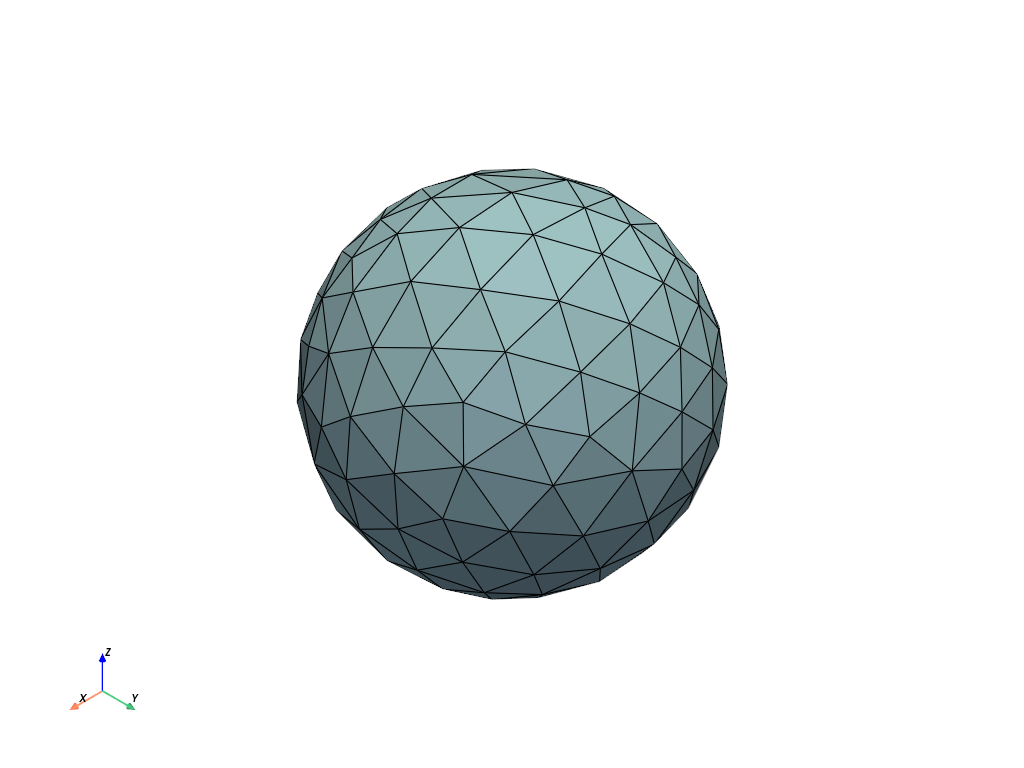

In [3]:
# 1. Espace de modélisation 3D
fd.ModelingSpace("3D")

# 2. Charger le maillage sphérique (Gmsh
mesh = pv.read("3DSphere.msh")
mesh = mesh.extract_cells_by_type(10)# Extraction des éléments de type 10 (tétraèdres = volume 3D)
mesh = fd.Mesh.from_pyvista(mesh)
mesh.plot()

In [4]:
# 3. Extraire les coordonnées des nœuds à la surface externe
surface_mesh = fd.mesh.extract_surface(mesh) # Extraire le maillage de surface
surface_nodes = np.unique(surface_mesh.elements) # Extraire les indices de nœuds à la surface

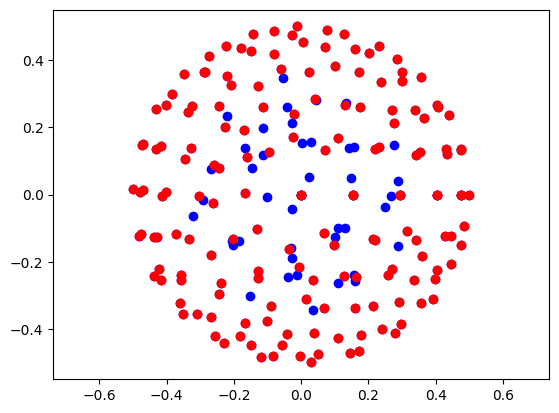

[0.49999997 0.5        0.49999997 0.49999997 0.5        0.5
 0.49999997 0.49999997 0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.49999997
 0.49999997 0.5        0.5        0.5        0.5        0.5
 0.5        0.49999997 0.5        0.5        0.5        0.5
 0.49999997 0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.49999997 0.5
 0.5        0.5        0.49999997 0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.49999997 0.5        0.5
 0.5        0.5        0.5        0.5        0.49999997 0.5
 0.49999997 0.5        0.5        0.49999997 0.5        0.49999997
 0.49999997 0.49999997 0.5        0.49999997 0.5        0.5
 0.5        0.5        0.5        0.49999997 0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5

In [5]:
import matplotlib.pyplot as plt

XYZ = mesh.nodes

plt.plot(XYZ[:,0],XYZ[:,1],'ob')
plt.plot(XYZ[surface_nodes,0],XYZ[surface_nodes,1],'or')
plt.axis('equal')
plt.show()



print(np.sqrt(XYZ[surface_nodes,0]**2+XYZ[surface_nodes,1]**2+XYZ[surface_nodes,2]**2))


In [7]:
# 4. Définir un matériau élastique isotrope 
# Module D'Young de l'acier
material = fd.constitutivelaw.ElasticIsotrop(200000, 0.3)


In [8]:
# 5. Définir le problème de mécanique 
# méthode numérique FEM
# mathematique appliqué : construire une forme faible du problème
# assembler le tout (mesh + comportement + forme faible) => un système à résoudre KU=F
wf = fd.weakform.StressEquilibrium(material)# equilibre des efforts
assembly = fd.Assembly.create(wf, mesh)

In [9]:
# 6. Créer le problème 
pb = fd.problem.Linear(assembly) 

In [6]:
# 7. Calculer le déplacement radial vers le centre (compaction) (Conditions aux limites)
X = mesh.nodes # Coordonnées des nœuds
r = np.linalg.norm(X[surface_nodes], axis=1)# Rayon de chaque nœud en surface
radial_dir = -X[surface_nodes] / r[:, None] # Vecteurs unitaires vers le centre
compaction = 0.05   # Facteur de compaction (5%)
u_compaction = compaction * radial_dir    # Déplacement imposé
radial_dir

pyvista_ndarray([[-8.89855504e-01,  2.45776728e-01,  3.84384006e-01],
                 [-7.97675669e-01,  5.03551960e-01,  3.31886947e-01],
                 [ 8.32262397e-01,  5.05208552e-01,  2.28262499e-01],
                 [ 7.01784015e-01,  7.11650729e-01,  3.24431472e-02],
                 [-3.19924831e-01, -8.62639248e-01,  3.91792804e-01],
                 [-2.00892404e-01, -7.61924863e-01,  6.15721345e-01],
                 [ 7.66519189e-01, -5.94942391e-01, -2.41851255e-01],
                 [-4.37152714e-01, -2.69817263e-01,  8.57960522e-01],
                 [-5.87785244e-01,  1.43961111e-16,  8.09017003e-01],
                 [-7.82938004e-01,  6.21686935e-01,  2.26589907e-02],
                 [ 8.59649003e-01, -2.70458877e-01,  4.33423102e-01],
                 [-6.12303177e-17,  1.49966072e-32, -1.00000000e+00],
                 [-7.19258130e-01,  3.67544055e-01,  5.89558423e-01],
                 [-6.81979239e-01, -2.33493045e-01,  6.93098307e-01],
                 [ 6

In [10]:
print("surface_nodes shape:", surface_nodes.shape)
print("u_compaction shape:", u_compaction.shape)
print("First few entries of u_compaction:\n", u_compaction[:5])


surface_nodes shape: (164,)
u_compaction shape: (164, 3)
First few entries of u_compaction:
 [[-0.04449278  0.01228884  0.0192192 ]
 [-0.03988378  0.0251776   0.01659435]
 [ 0.04161312  0.02526043  0.01141313]
 [ 0.0350892   0.03558254  0.00162216]
 [-0.01599624 -0.04313196  0.01958964]]


In [11]:
# 8. Appliquer les déplacements imposés sur la surface
pb.bc.add("Dirichlet", surface_nodes, "DispX", u_compaction[:,0])
pb.bc.add("Dirichlet", surface_nodes, "DispY", u_compaction[:,1])
pb.bc.add("Dirichlet", surface_nodes, "DispZ", u_compaction[:,2])



Dirichlet boundary condition:
var = 'DispZ'
n_nodes = 164
value = array

In [12]:
# 9. resolution

pb.solve()


c:\Users\okouo\miniconda3\envs\Fedoo_DSTI\Lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


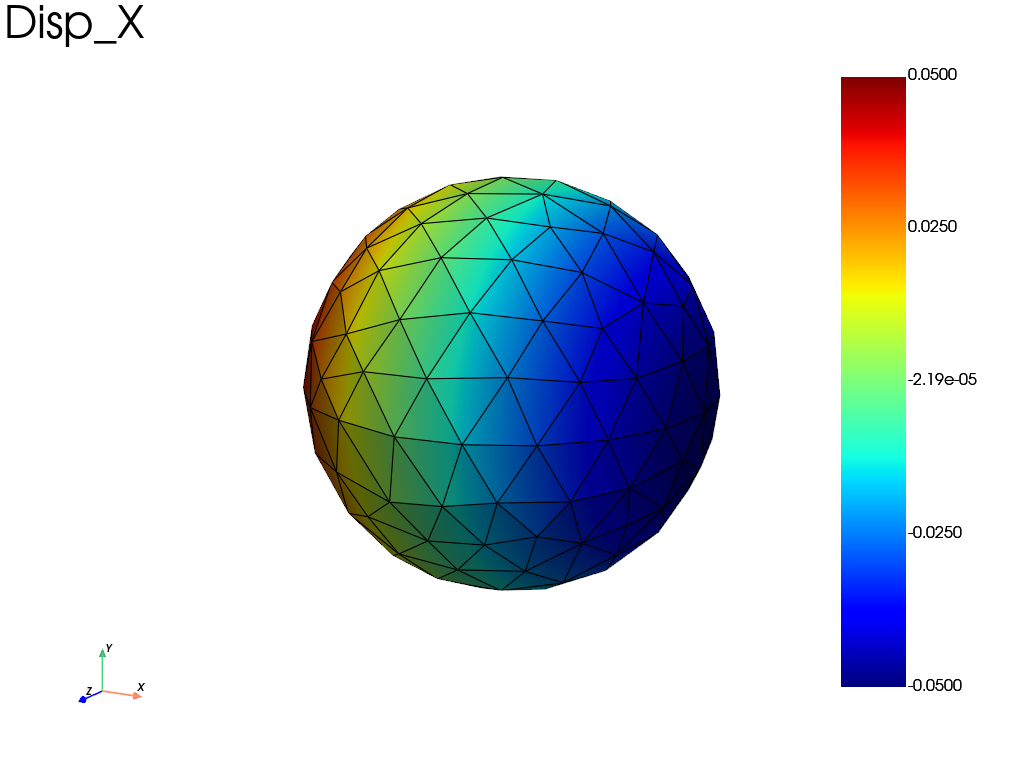

In [14]:
# 10. Affichage du champ de déplacement
results = pb.get_results(assembly, ["Stress", "Strain", "Disp", "Fext"])
results.plot("Disp",'X')
results.save('output.vtk')

# Vue sur Paraview :

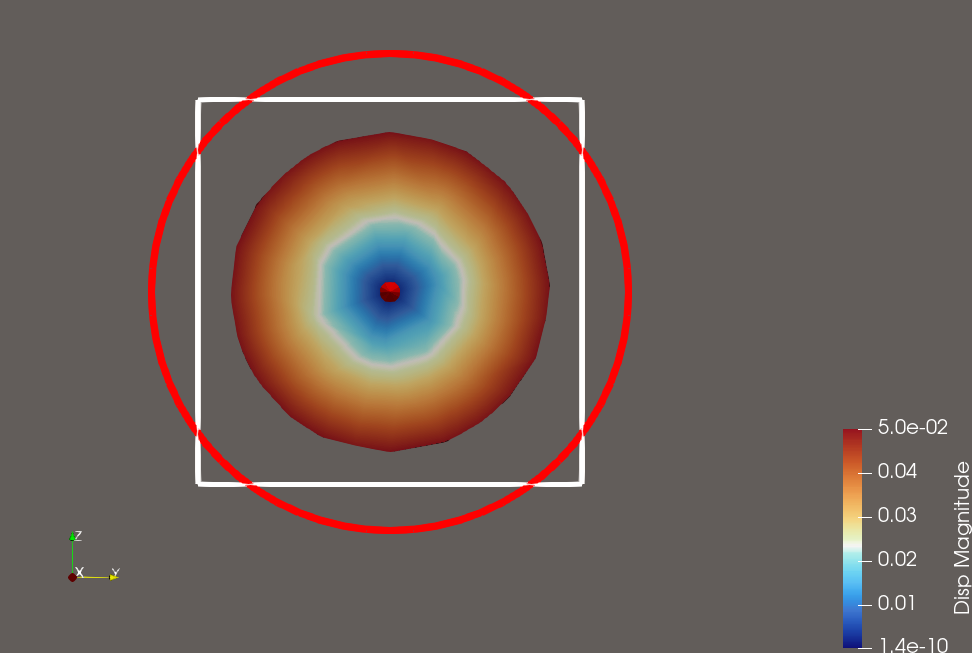